<a href="https://colab.research.google.com/github/Sen-Ma/PUBG-Kaggle/blob/master/Effective_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import random 
random.seed(42)

import warnings 
warnings.filterwarnings("ignore", category = DeprecationWarning)

def reload():
  gc.collect()
  df = pd.read_csv('train_V2.csv')
  invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
  df = df[-df['matchId'].isin(invalid_match_ids)]
  return df

# train = pd.read_csv("/content/gdrive/My Drive/pubg/train_V2.csv")

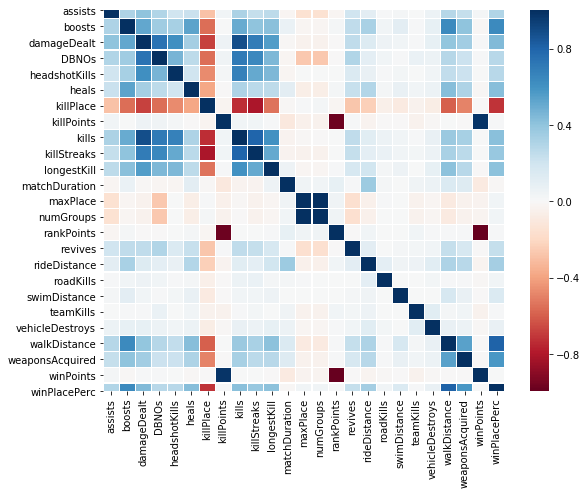

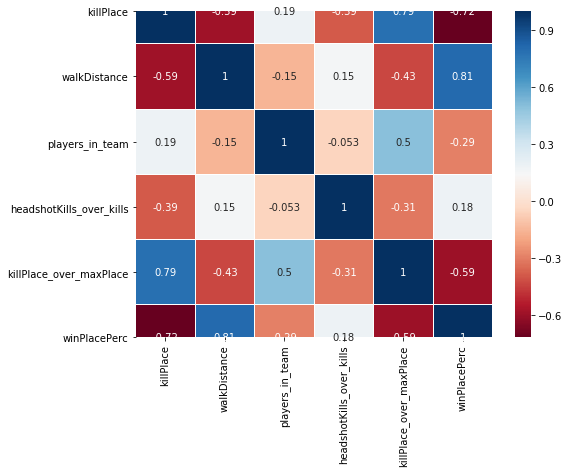

In [2]:
df = reload()
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize = (9,7))
sns.heatmap(
    corr,
    xticklabels = corr.columns.values,
    yticklabels = corr.columns.values,
    linecolor = 'white', 
    linewidths = 0.1,
    cmap = "RdBu"
)

plt.show()

agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg,how='left', on = ['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace =True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace = True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace = True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize = (8,6))
sns.heatmap(
    corr,
    xticklabels = corr.columns.values,
    yticklabels = corr.columns.values,
    annot = True,
    linecolor = 'white',
    linewidth = 0.1,
    cmap = "RdBu"
)
plt.show()

In [3]:
def train_test_split(df, test_size = 0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1-test_size))
    train_match_ids = random.sample(match_ids, train_size)
    
    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):
    df = reload()
    df.drop(columns = ['matchType'], inplace = True)
    
    df = preprocess(df)
    
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train, val = train_test_split(df, 0.1)
    
    model = LinearRegression()
    model.fit(train[cols_to_fit], train[target])
    
    y_true = val[target]
    y_pred = model.predict(val[cols_to_fit])
    return mean_absolute_error(y_true, y_pred)

def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time() -start
        results.append({
            'name' : preprocess.__name__,
            'score' : score,
            'execution time' : f'{round(execution_time,2)}s'
            
        })
        gc.collect()
        
    return pd.DataFrame(results, columns = ['name', 'score', 'execution time']).sort_values(by = 'score')

In [25]:
def original(df):
    return df 

def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df 

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace = True)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace = True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace =True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace = True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace = True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace = True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace = True)
    return df 
def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives'] 
    return df 

In [27]:
run_experiments([
    original,
    items,
    players_in_team,
    total_distance,
    headshotKills_over_kills,
    killPlace_over_maxPlace,
    walkDistance_over_heals,
    walkDistance_over_kills,
    teamwork
])

,name,score,execution time
2,players_in_team,0.091098,23.9s
4,headshotKills_over_kills,0.091810,14.07s
5,killPlace_over_maxPlace,0.091885,13.84s
1,items,0.092270,14.0s
7,walkDistance_over_kills,0.092478,14.06s
8,teamwork,0.092535,14.0s
3,total_distance,0.092571,13.99s
6,walkDistance_over_heals,0.092999,14.12s
0,original,0.093180,13.92s


In [39]:
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].min()
    return df.merge(agg, suffixes = ['', '_min'], how = 'left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes = ['', '_max'], how= 'left', on=['matchId','groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes = ['', '_sum'], how = 'left', on = ['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId','matchId','winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes = ['', '_median'], how = 'left', on = ['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId','matchId','winPlaceperc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes = ['', '_mean'], how = 'left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id','groupId','matchId','winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct = True)
    return df.merge(agg, suffixes = ['', '_mean_rank'], how = 'left', on = ['matchId', 'groupId'])

In [40]:
run_experiments([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

,name,score,execution time
5,mean_by_team,3.969172e-15,34.05s
6,rank_by_team,5.796754e-02,42.33s
4,median_by_team,7.654205e-02,34.68s
2,max_by_team,7.834846e-02,36.75s
3,sum_by_team,8.811207e-02,37.49s
1,min_by_team,9.005652e-02,36.21s
0,original,9.250792e-02,14.08s


[20]	valid_0's l1: 0.0656693
[40]	valid_0's l1: 0.0622235
[60]	valid_0's l1: 0.060847
[80]	valid_0's l1: 0.0602121
[100]	valid_0's l1: 0.059715


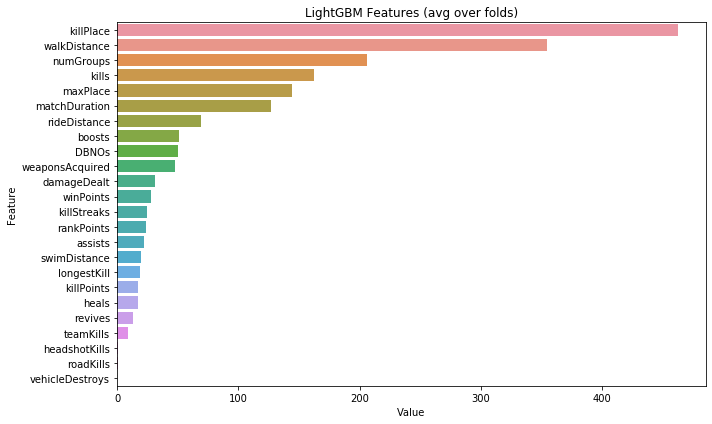

In [45]:
df = reload()

df.drop(columns = ['matchType'], inplace = True)
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId','matchId','matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)

from lightgbm import LGBMRegressor
params = {
    'n_estimators':100,
    'learning_rate':0.3,
    'num_leaves' : 20,
    'objective' : 'regression_l2',
    'metric' : 'mae',
    'verbose' : -1,
    
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set = [(val[cols_to_fit], val[target])],
    eval_metric = 'mae',
    verbose = 20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns= ['Value', 'Feature'])

plt.figure(figsize = (10,6))
sns.barplot(x = "Value", y = "Feature", data = feature_importance.sort_values(by="Value", ascending = False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [50]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state = 42).fit(val[cols_to_fit], val[target])
eli5.show_weights(perm, feature_names = list(cols_to_fit))


Weight,Feature
1.3479 ± 0.0053,killPlace
0.3238 ± 0.0027,kills
0.3096 ± 0.0015,walkDistance
0.0658 ± 0.0002,numGroups
0.0337 ± 0.0002,maxPlace
0.0305 ± 0.0007,matchDuration
0.0111 ± 0.0001,killStreaks
0.0071 ± 0.0001,rideDistance
0.0062 ± 0.0000,boosts
0.0036 ± 0.0001,weaponsAcquired


In [52]:
import shap
shap.initjs()

In [53]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val[cols_to_fit])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


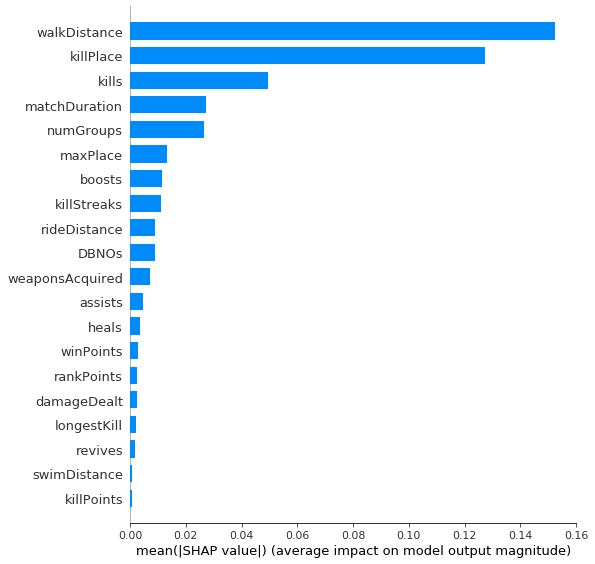

In [54]:
shap.summary_plot(shap_values, val[cols_to_fit], plot_type = 'bar')

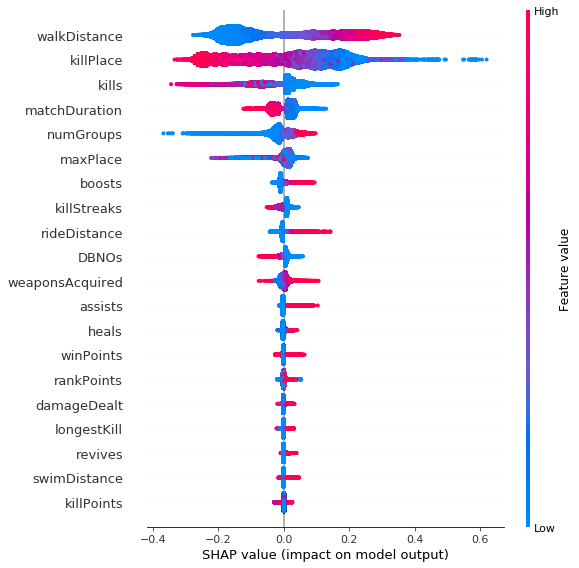

In [56]:
shap.summary_plot(shap_values, val[cols_to_fit], feature_names = cols_to_fit)

Effective_Feature_Engineering 에서 기존 내용과 달랐던 부분은 SHAP 와 Eli5를 사용했다는 것이다. 기존 heatmap이나 correlation에서와 달리 SHAP 는 각 값에 얼마나 영향을 끼쳤는지 공헌도를 나타내는 것이다. 인상적인 부분은 상관계수는 언제나 killPlace가 높았지만 공헌도는 walkDistance가 월등히 높다는 것이었다. 다만 어느정도의 숫자를 넘어가게 된다면 전혀 영향을 끼치지 않는다는 것을 위 그래프를 통해 알 수 있었다. 앞으로 있을 EDA에서는 SHAP를 필수적으로 사용하여 각 변수가 얼마만큼의 공헌도를 가지고 있는지를 확인해 보아야 겠다.